In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tikzplotlib
import os

import scipy.stats as st

In [16]:
scratchHPC = r'O:\scratch\MultiPhase'

In [17]:
StudienOrdner = '211105_Volstudie_lower5p_37HRC'
StudienOrdner = os.path.join(scratchHPC, StudienOrdner)

In [18]:
lf_csv = r'_eval/lifetime.csv'
lf_csv = os.path.join(StudienOrdner, lf_csv)

In [19]:
os.path.isdir(scratchHPC)

True

In [20]:
df_lf = pd.read_csv(lf_csv)

In [21]:
ll_volf = df_lf['ModelName'].tolist()
ll_volf = [float(kk[kk.rfind('_')+15:])   for kk in ll_volf]

ll_Seed = df_lf['ModelName'].tolist()
ll_Seed = [str(kk[kk.find('_')+5:kk.find('Strain')-1])   for kk in ll_Seed]

In [22]:
minimia_vol = min(ll_volf)
maxima_vol = max(ll_volf)

In [23]:
df_lf['Volume_Martensite'] = ll_volf
df_lf['Seed'] = ll_Seed

df_wholMod = df_lf[df_lf['Phase']=='wholeMod']

In [24]:
norm = matplotlib.colors.Normalize(vmin=minimia_vol, vmax=maxima_vol, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm) 

In [25]:
from scipy import optimize

def tfunktion(x_data, a,b):
    return a*(x_data**2)+b*x_data+x_data


In [26]:
params, params_covariance = optimize.curve_fit(tfunktion, df_wholMod['Lifetime'].tolist(), df_wholMod['StrainAmplitude'].tolist(),)

In [27]:
colorswhole = df_wholMod['Volume_Martensite'].tolist()
un_voll = np.unique(colorswhole)
colorswhole = [float(c) for c in colorswhole]

strain_ll = np.unique(df_wholMod['StrainAmplitude'].tolist())

dic_f_curve = {}
for  vol in un_voll:
    df_red = df_wholMod[df_wholMod['Volume_Martensite']==vol]
    params, params_covariance = optimize.curve_fit(tfunktion, df_red['Lifetime'].tolist(), df_red['StrainAmplitude'].tolist())
    
    ll_mean_lifetimes = [np.min(df_red[df_red['StrainAmplitude']==stra]['Lifetime'].tolist()) for stra in strain_ll]
    print(ll_mean_lifetimes)
    f_curve = [tfunktion(lf, params[0], params[1]) for lf in ll_mean_lifetimes]
    dic_f_curve[vol] = f_curve

print(dic_f_curve)

[20615.11055587117, 3001.841639871302, 723.3673061784642]
[21264.48885472474, 2461.569195083248, 723.049411632934]
[28132.767011088465, 2567.1585426362744, 574.6643856561511]
[28522.091133997877, 2183.323546038724, 518.9097898363085]
[23061.181044597743, 2462.5428016611545, 709.386759515924]
{95.0: [0.003879604282701621, 0.0007294119554899225, 0.00018089724903802562], 96.0: [0.006162851586850593, 0.0010874553554458544, 0.0003295825015356968], 97.0: [0.00539825190207921, 0.0008021244157134788, 0.00018495747406177543], 98.0: [0.007927378126623807, 0.0012281838407943724, 0.0003012341484236458], 99.0: [0.006422369562642416, 0.0011086991185038642, 0.00032975243061628134]}


Text(0, 0.5, 'Strain')

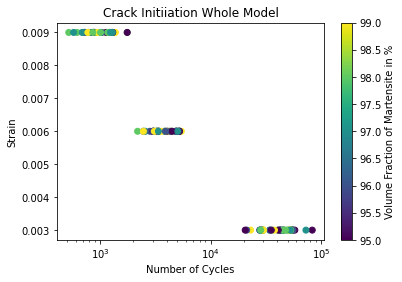

In [28]:

plt.scatter(df_wholMod['Lifetime'], df_wholMod['StrainAmplitude'], c=colorswhole)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Whole Model')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
#plt.show()


#plt.savefig(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

In [29]:
df_Ferrite = df_lf[df_lf['Phase']=='Ferrite']

In [30]:
colorsFerr = df_Ferrite['Volume_Martensite'].tolist()
colorsFerr = [float(c) for c in colorsFerr]

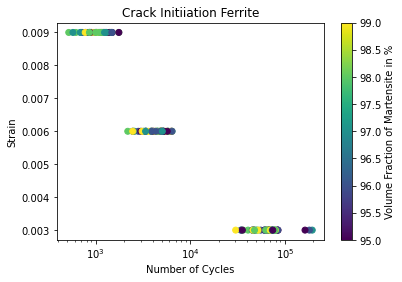

In [31]:
plt.scatter(df_Ferrite['Lifetime'], df_Ferrite['StrainAmplitude'], c=colorsFerr)
cbar = plt.colorbar()
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Ferrite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

In [32]:
df_mart = df_lf[df_lf['Phase']=='Martensite']

In [33]:
colorsMart = df_mart['Volume_Martensite'].tolist()
colorsMart = [int(c) for c in colorsMart]

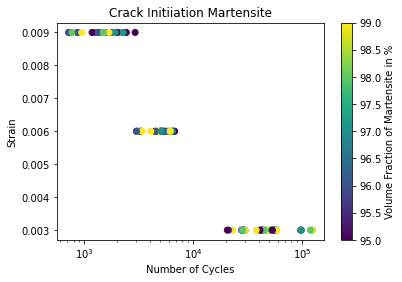

In [34]:
plt.scatter(df_mart['Lifetime'], df_mart['StrainAmplitude'], c=colorsMart)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Martensite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

Abwärts erstelle confidence intervalle

In [35]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_conf = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['Lifetime'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_conf[dd] = df_conf

Plotten der confidence Intervalle

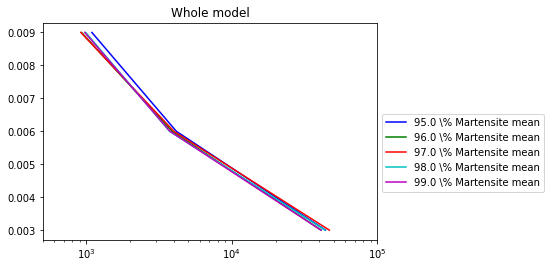

In [44]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['whole']
ll_volf = [kk  for kk in ll_volf if kk not in [75.0, 80.0]]
for num, vols in enumerate(np.unique(ll_volf)):

    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.title('Whole model')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )
plt.xlim([5*10**2,10**5])

tikzplotlib.save(os.path.join(StudienOrdner, 'ConfLifetimeWholeMod.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

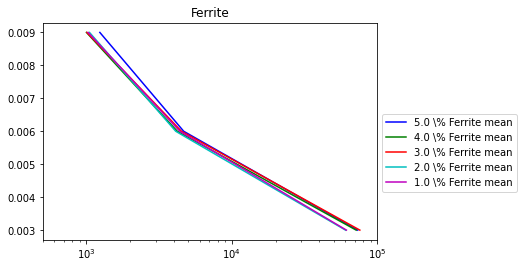

In [45]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Ferrite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    #if num%2 == 0:
        volls_red.append(vols)
    
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(100-vols)+' \% Ferrite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.title('Ferrite')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )
plt.xlim([5*10**2,10**5])

tikzplotlib.save(os.path.join(StudienOrdner, 'ConfLifetimeFerrite.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeFerrite.png'), bbox_inches='tight', dpi=150, transparent=True)


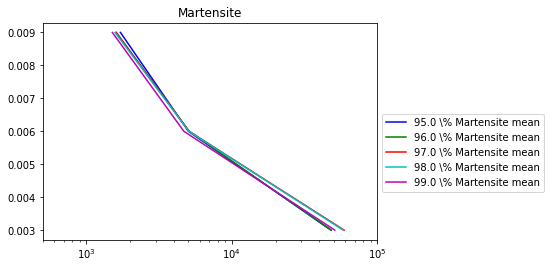

In [46]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Martensite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    #if num%2 == 0:
        volls_red.append(vols)
#volls_red = [85.0,90.0,95.0,100.0]
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.xlim([5*10**2,10**5])
plt.legend(loc = 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )
plt.title('Martensite')


tikzplotlib.save(os.path.join(StudienOrdner, 'ConfLifetimeMartensite.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeMartensite.png'), bbox_inches='tight', dpi=150, transparent=True)


In [47]:
### AChtung lower bound ist nicht ganz korrekt das dieser durch die große varianz eine negative Lebensdauer angeben würde
### dacher ist in diesen Fällen der Lower Bound = minimum der Lebenszeit für definierte Dehnung und Volumengehalt

In [48]:
mnbv= df_lf[df_lf['StrainAmplitude']==0.009]
mnbv= mnbv[mnbv['Seed']=='93426']
mnbv[mnbv['Volume_Martensite'].isin([95.0,75.0])]

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
18,6.0,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,895.036824,wholeMod,0.0,0.009,0.0,987.54,-1.249,0.048927,0.107422,2.521240,1.724138,0,95.0,93426
19,6.1,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,1605.100320,Martensite,0.0,0.009,0.0,987.54,-1.249,0.025863,0.081032,1.870093,1.724138,0,95.0,93426
20,6.2,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,895.036824,Ferrite,0.0,0.009,0.0,987.54,-1.249,0.048927,0.107422,2.521240,1.724138,0,95.0,93426


Bestimme liegt geringste Lebenszeit immer mit Ferrit zusammen? 

In [49]:
df_03 = df_lf[df_lf['StrainAmplitude']==0.003]
df_06 = df_lf[df_lf['StrainAmplitude']==0.006]
df_09 = df_lf[df_lf['StrainAmplitude']==0.009]

In [53]:
c_df = df_09 
ll_model = c_df['Unnamed: 0'].tolist()


ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = c_df[c_df['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        
        for ph in phases:
            if float(c_df[c_df['Unnamed: 0'] == ph]['Lifetime']) == float(ltime):
                ll_prob_phase.append([len(phases),df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]])        

print(np.unique(ll_prob_phase,axis=0))

[['2' 'Ferrite']
 ['2' 'Martensite']]


In [54]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        ltime = 9e300
        phaseprob = ''
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) < ltime:
                ltime = float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime'])
                phaseprob = df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]
        ll_prob_phase.append([len(phases),phaseprob])        

print(np.unique(ll_prob_phase,axis=0))

[['2' 'Ferrite']
 ['2' 'Martensite']]


In [55]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_StressAmp = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['StressAmplitude'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_StressAmp[dd] = df_conf

Plotten confidence Intervalle bezogen auf Stress::

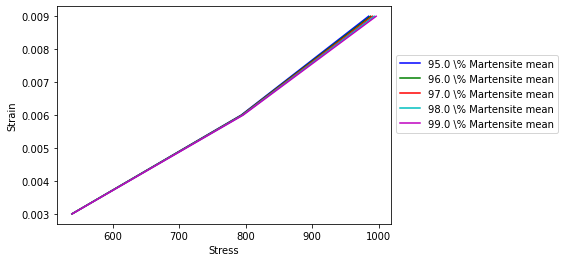

In [56]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']

df_conf = dic_df_StressAmp['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
#plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8), ncol=1 )
plt.xlabel('Stress')
plt.ylabel('Strain')
plt.title('')


tikzplotlib.save(os.path.join(StudienOrdner, 'StressAmplitude.tex'))
plt.savefig(os.path.join(StudienOrdner, 'StressAmplitude.png'), bbox_inches='tight', dpi=150, transparent=True)


In [36]:
df_conf

,StrainAmplitude,l_bound VolF 75.0,mean VolF 75.0,u_bound VolF 75.0,l_bound VolF 80.0,mean VolF 80.0,u_bound VolF 80.0,l_bound VolF 85.0,mean VolF 85.0,u_bound VolF 85.0,l_bound VolF 90.0,mean VolF 90.0,u_bound VolF 90.0,l_bound VolF 95.0,mean VolF 95.0,u_bound VolF 95.0,l_bound VolF 100.0,mean VolF 100.0,u_bound VolF 100.0
0,0.003,597.358805,597.89685,598.434895,602.960271,603.4456,603.930929,608.509463,609.01435,609.519237,614.059961,614.64785,615.235739,619.664959,620.40605,621.147141,625.320210,625.8033,626.286390
1,0.006,1013.479630,1016.18950,1018.899370,1039.756564,1041.9895,1044.222436,1066.717318,1068.57550,1070.433682,1094.632513,1096.21350,1097.794487,1123.468423,1125.16250,1126.856577,1154.470332,1155.3550,1156.239668
2,0.009,1335.684642,1341.36850,1347.052358,1394.812067,1399.3035,1403.794933,1456.208419,1459.65850,1463.108581,1520.394653,1523.18100,1525.967347,1587.246359,1590.09100,1592.935641,1660.758063,1662.0265,1663.294937


In [62]:
df_wholMod

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
0,0.0,DisTest_Seed36003_Strain0p6_VolumeFraction97,ALL,2567.158543,wholeMod,0.0,0.006,0.0,797.5710,-0.2340,0.026554,0.049918,2.521240,1.724138,0,97.0,36003
3,1.0,DisTest_Seed81296_Strain0p6_VolumeFraction96,ALL,4929.265818,wholeMod,0.0,0.006,0.0,793.6320,-0.2510,0.018189,0.048648,2.521240,1.724138,0,96.0,81296
6,2.0,DisTest_Seed93426_Strain0p3_VolumeFraction97,ALL,49675.508175,wholeMod,0.0,0.003,0.0,540.9525,-0.0145,0.004763,0.008904,2.521240,1.724138,0,97.0,93426
9,3.0,DisTest_Seed45213_Strain0p3_VolumeFraction99,ALL,30063.158664,wholeMod,0.0,0.003,0.0,537.5460,-0.0110,0.004727,0.008844,1.870093,1.724138,0,99.0,45213
12,4.0,DisTest_Seed25609_Strain0p6_VolumeFraction98,ALL,4391.137373,wholeMod,0.0,0.006,0.0,795.6530,-0.2180,0.019450,0.036762,2.521240,1.724138,0,98.0,25609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,144.0,DisTest_Seed36003_Strain0p9_VolumeFraction99,ALL,774.397115,wholeMod,0.0,0.009,0.0,1001.8650,-1.3650,0.053213,0.104384,2.521240,1.724138,0,99.0,36003
435,145.0,DisTest_Seed81296_Strain0p3_VolumeFraction95,ALL,20615.110556,wholeMod,0.0,0.003,0.0,538.6000,-0.0170,0.005883,0.009344,1.870093,1.724138,0,95.0,81296
438,146.0,DisTest_Seed36003_Strain0p3_VolumeFraction95,ALL,35564.267293,wholeMod,0.0,0.003,0.0,540.4905,-0.0195,0.005781,0.009727,2.521240,1.724138,0,95.0,36003
441,147.0,DisTest_Seed93426_Strain0p9_VolumeFraction98,ALL,858.065740,wholeMod,0.0,0.009,0.0,996.9605,-1.3075,0.050139,0.099256,2.521240,1.724138,0,98.0,93426


try boxplot

In [63]:
df_wholMod_96 = df_wholMod[df_wholMod['Volume_Martensite'] == 96.0]

In [64]:
df_wholMod_96

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
3,1.0,DisTest_Seed81296_Strain0p6_VolumeFraction96,ALL,4929.265818,wholeMod,0.0,0.006,0.0,793.6320,-0.2510,0.018189,0.048648,2.521240,1.724138,0,96.0,81296
30,10.0,DisTest_Seed61442_Strain0p3_VolumeFraction96,ALL,55493.353313,wholeMod,0.0,0.003,0.0,538.9200,-0.0160,0.004466,0.009671,2.521240,1.724138,0,96.0,61442
45,15.0,DisTest_Seed36003_Strain0p3_VolumeFraction96,ALL,34507.624166,wholeMod,0.0,0.003,0.0,540.7200,-0.0180,0.005883,0.010405,2.521240,1.724138,0,96.0,36003
51,17.0,DisTest_Seed22187_Strain0p9_VolumeFraction96,ALL,1265.717390,wholeMod,0.0,0.009,0.0,984.1860,-1.2490,0.040018,0.102696,2.521240,1.724138,0,96.0,22187
54,18.0,DisTest_Seed36003_Strain0p9_VolumeFraction96,ALL,787.859542,wholeMod,0.0,0.009,0.0,991.9675,-1.3145,0.052683,0.109885,2.521240,1.724138,0,96.0,36003
75,25.0,DisTest_Seed54667_Strain0p6_VolumeFraction96,ALL,4023.840847,wholeMod,0.0,0.006,0.0,794.3900,-0.2440,0.020461,0.041280,2.521240,1.724138,0,96.0,54667
93,31.0,DisTest_Seed93426_Strain0p9_VolumeFraction96,ALL,779.826117,wholeMod,0.0,0.009,0.0,990.7155,-1.2705,0.052998,0.106696,2.521240,1.724138,0,96.0,93426
99,33.0,DisTest_Seed93426_Strain0p3_VolumeFraction96,ALL,42999.903350,wholeMod,0.0,0.003,0.0,540.6990,-0.0160,0.004923,0.009113,1.870093,1.724138,0,96.0,93426
129,43.0,DisTest_Seed36003_Strain0p6_VolumeFraction96,ALL,2823.873838,wholeMod,0.0,0.006,0.0,796.6040,-0.2380,0.025126,0.049025,2.521240,1.724138,0,96.0,36003
171,57.0,DisTest_Seed61442_Strain0p9_VolumeFraction96,ALL,866.819728,wholeMod,0.0,0.009,0.0,987.4150,-1.2830,0.049844,0.107572,2.521240,1.724138,0,96.0,61442


In [73]:
un_load = {}
for kk in np.unique(df_wholMod_96['StrainAmplitude'].tolist()):
    un_load[kk] = df_wholMod_96[df_wholMod['StrainAmplitude'] == kk]

 

C:\Users\hro7rng\.conda\envs\graingen\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hro7rng\.conda\envs\graingen\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hro7rng\.conda\envs\graingen\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
Life_list = [ite['Lifetime'].tolist() for kk, ite in un_load.items()]
num_st = [nn for nn in un_load]
num_ll = [nn+1 for nn, wrt in enumerate(Life_list)]

([<matplotlib.axis.XTick at 0x1fc040fcc08>,
 [Text(1, 0, '0.003'), Text(2, 0, '0.006'), Text(3, 0, '0.009')])

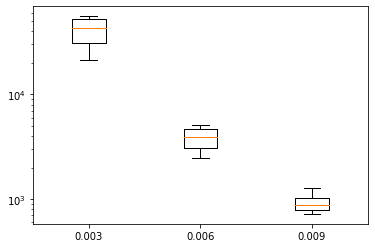

In [108]:
plt.boxplot(Life_list)
plt.yscale('log')
plt.xticks(num_ll, num_st)